In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import csv

In [2]:
from enums import stage_dict, char_dict, platform_dict, dan_names_dict
from read_data import read_data_into_dataframe
from data_processing import get_unique_players, calculate_win_rates_with_confidence_interval, get_most_popular_characters, get_rank_distribution, split_unique_players, split_replays_into_categories, calculate_percentiles
from plotting import plot_win_rates, plot_most_popular_characters, plot_rank_distribution, plot_win_rates_with_confidence_intervals

In [3]:
%matplotlib inline  

In [4]:
jsons_directory = './data/'
master_df = read_data_into_dataframe(jsons_directory)

Read 4440555 games from 4445 files
26 files were unable to be read


In [5]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 675466 entries, 0 to 4440554
Data columns (total 35 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   battleId       675466 non-null  object
 1   battleType     675466 non-null  int64 
 2   gameVersion    675466 non-null  int64 
 3   winResult      675466 non-null  int64 
 4   totalRoundNum  675466 non-null  int64 
 5   battleAt       675466 non-null  int64 
 6   viewNum        675466 non-null  int64 
 7   stageId        675466 non-null  object
 8   highlightFlag  675466 non-null  bool  
 9   1pUserId       675466 non-null  object
 10  1pPlayerName   675466 non-null  object
 11  1pPolarisId    675466 non-null  object
 12  1pOnlineId     675466 non-null  object
 13  1pNgWordFlag   675466 non-null  int64 
 14  1pPlatform     675466 non-null  int64 
 15  1pRank         675466 non-null  int64 
 16  1pTekkenPower  675466 non-null  int64 
 17  1pCharaId      675466 non-null  object
 18  1pWinRou

In [6]:
unique_players = get_unique_players(master_df)
beginner_players, intemediate_players, advanced_players = split_unique_players(unique_players)
beginner_games, intermediate_games, advanced_games = split_replays_into_categories(master_df)

In [7]:
print('Number of unique players:', len(unique_players))
print('Number of beginner players:', len(beginner_players))
print('Number of intermediate players:', len(intemediate_players))
print('Number of advanced players:', len(advanced_players))
print('')
print('Number of unique games:', len(master_df))
print('Number of beginner games:', len(beginner_games))
print('Number of intermediate games:', len(intermediate_games))
print('Number of advanced games:', len(advanced_games))

print('')
print(f'{len(master_df) - (len(beginner_games) + len(intermediate_games) + len(advanced_games))} games were not categorized as they were played by players of from different categories')

Number of unique players: 165878
Number of beginner players: 51976
Number of intermediate players: 101954
Number of advanced players: 11948

Number of unique games: 675466
Number of beginner games: 140773
Number of intermediate games: 371017
Number of advanced games: 39602

124074 games were not categorized as they were played by players of from different categories


In [17]:
brackets_dict = {
	'beginner': {
		'players': beginner_players,
		'games': beginner_games,
		},
		'intermediate': {
			'players': intemediate_players,
			'games': intermediate_games,
		},
		'advanced': {
			'players': advanced_players,
			'games': advanced_games,
		},
} 


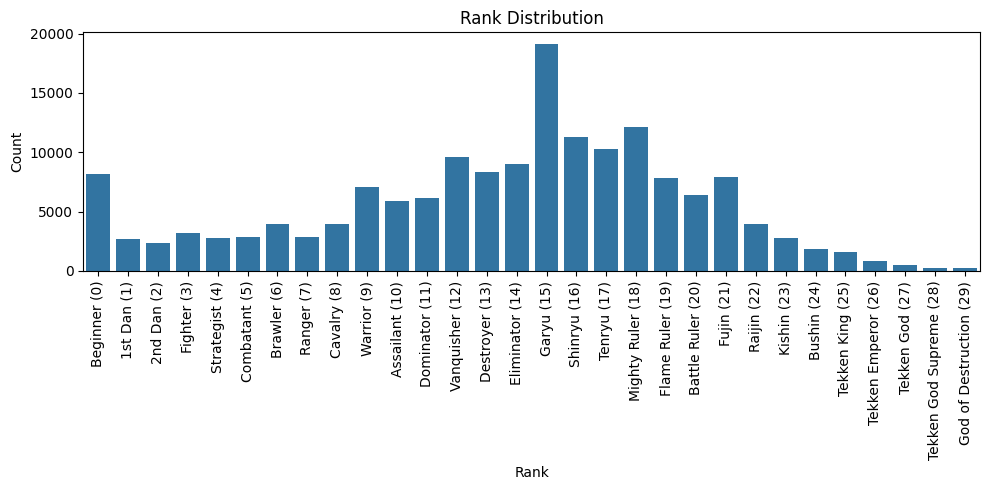

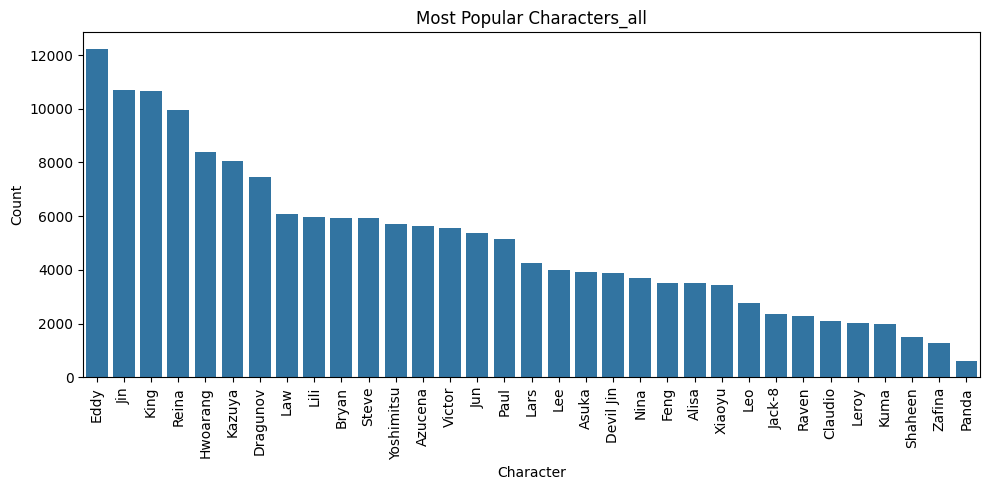

Number of mirror matches: 34920
Number of matches with draws: 0


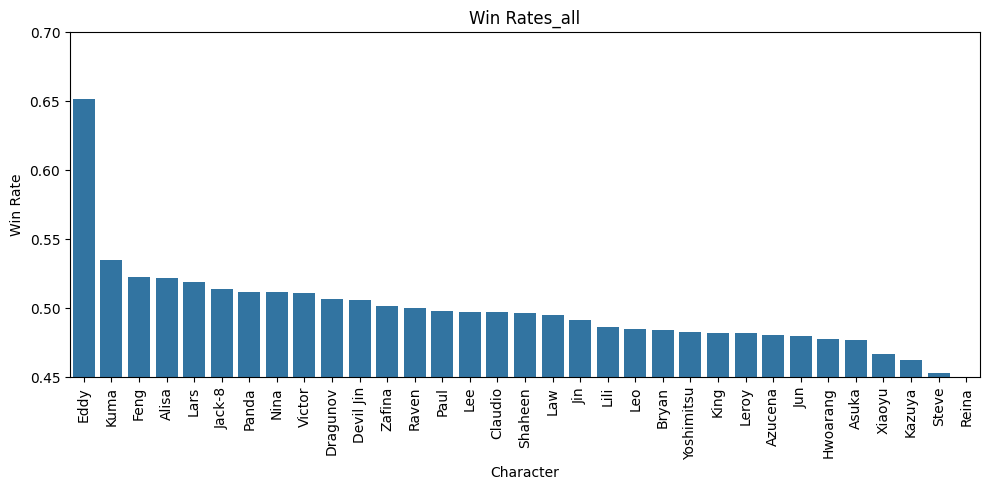

Number of mirror matches: 10981
Number of matches with draws: 0


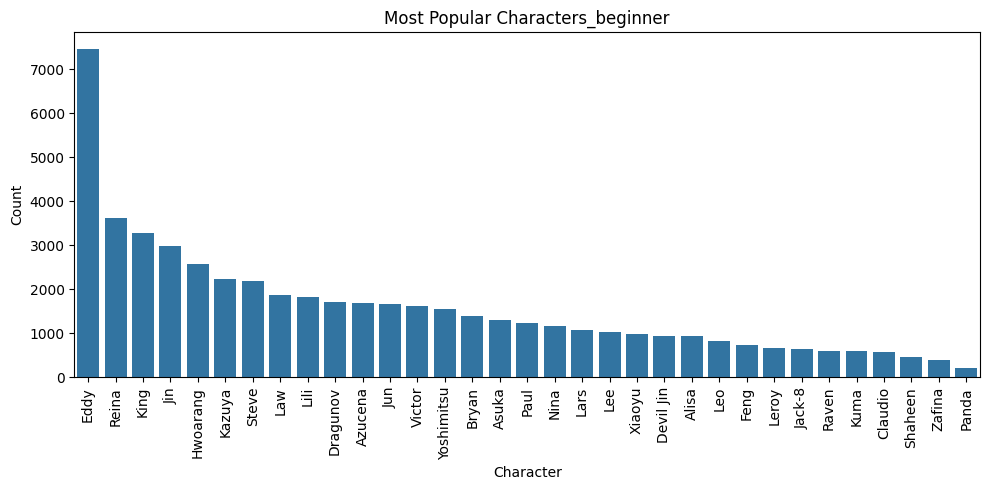

0 0.710768566260832 0.706152309478174 0.71538482304349
1 0.5350414468726451 0.521665410700829 0.5484174830444611
2 0.524008350730689 0.5091626072836929 0.538854094177685
3 0.5224011713030746 0.505710102489019 0.5390922401171303
4 0.5010344827586207 0.48810344827586205 0.5139655172413793
5 0.5007237984944991 0.4889982628836132 0.5124493341053851
6 0.5005905179686182 0.48793656149822845 0.5132444744390079
7 0.498264558426533 0.4872091528474097 0.5093199640056563
8 0.497289972899729 0.481029810298103 0.513550135501355
9 0.49632892804698975 0.4859369705184683 0.5067208855755111
10 0.49619076641779675 0.48765808319366144 0.504723449641932
11 0.48515769944341375 0.4678416821273964 0.5024737167594311
12 0.48428927680798006 0.47331670822942645 0.4952618453865337
13 0.4841837353048115 0.4733971639801236 0.4949703066294995
14 0.47819084686619245 0.4669171923231781 0.4895987115823379
15 0.47764076660228794 0.4657554598128064 0.4895260733917694
16 0.47548831865185753 0.46189199540405973 0.48908464

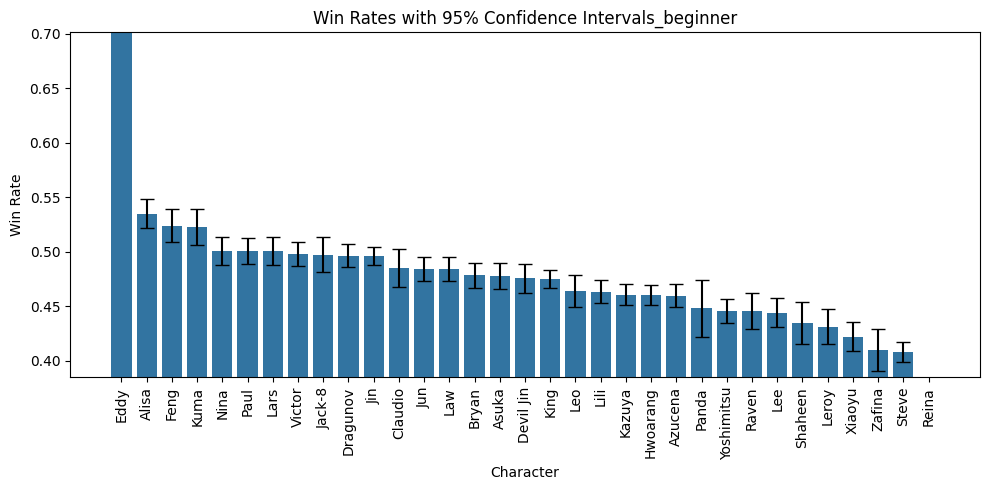

Number of mirror matches: 15947
Number of matches with draws: 0


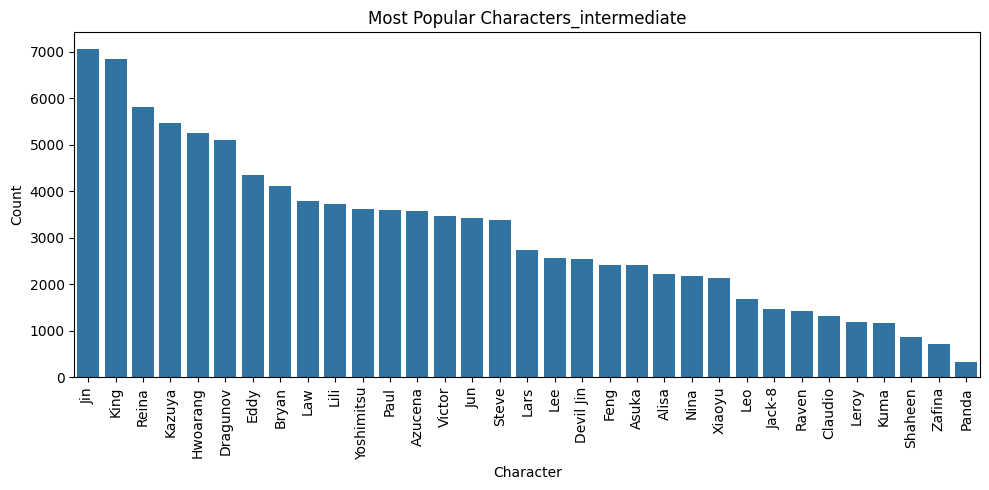

0 0.6343046033300686 0.6296278158667973 0.6389813907933398
1 0.5453492859899652 0.526051717483597 0.5646468544963335
2 0.5418060200668896 0.5290969899665552 0.5543478260869565
3 0.5393884426017103 0.5282456594972791 0.5505312257061414
4 0.5242799888153602 0.5148662503495199 0.5336937272812005
5 0.5233459825111367 0.5160864543804653 0.5306055106418083
6 0.5224043715846994 0.5102263856362217 0.5345823575331772
7 0.5211901732406773 0.5115004404424 0.5308799060389546
8 0.5196655518394648 0.5116387959866221 0.5276923076923077
9 0.5180340223944875 0.5108742463393626 0.5251937984496124
10 0.5163673623469773 0.5091948444156824 0.5235398802782721
11 0.5161170574769536 0.5083833446761121 0.5238507702777949
12 0.5112728853153692 0.5040473732819036 0.5184983973488346
13 0.5088859163004013 0.502102044716224 0.5156697878845786
14 0.5037998092871384 0.4985407576501864 0.5090588609240905
15 0.500965250965251 0.49077649077649077 0.5111540111540112
16 0.5006845708267509 0.4906793048973144 0.510689836756

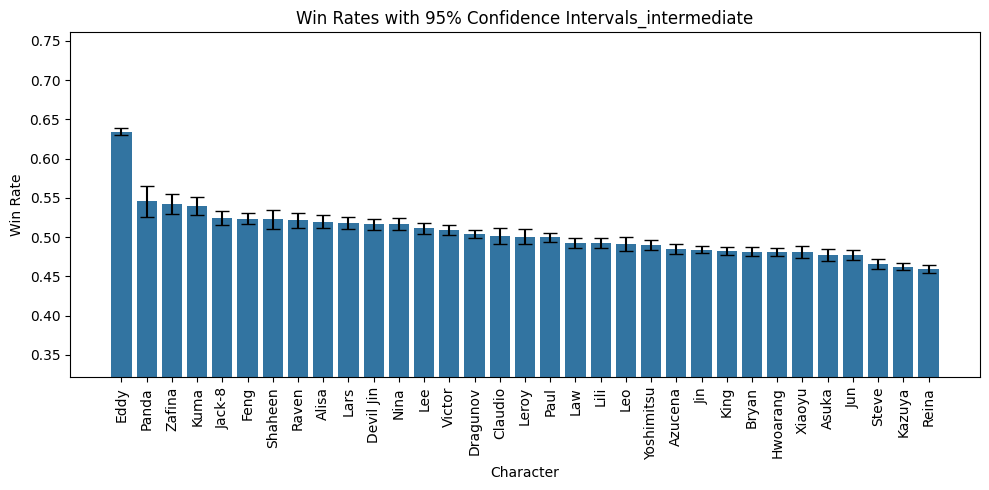

Number of mirror matches: 1689
Number of matches with draws: 0


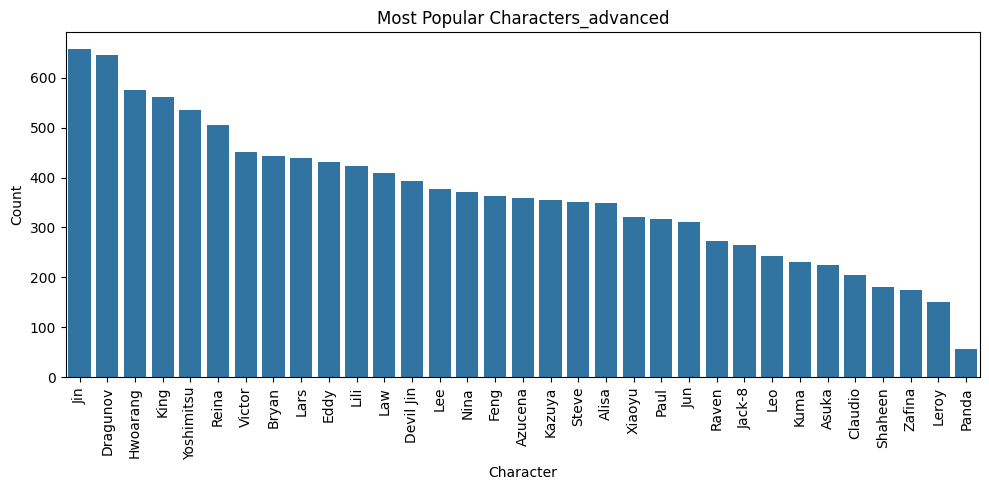

0 0.5777543489720611 0.5619399051133368 0.5935687928307855
1 0.5292397660818714 0.4766081871345029 0.5818713450292398
2 0.5205595591352268 0.5002119542178889 0.5409071640525647
3 0.5186693822131704 0.5006788866259335 0.5366598778004074
4 0.5172587553539935 0.5016376921138825 0.5328798185941043
5 0.5092905405405406 0.48057432432432434 0.5380067567567568
6 0.5079588014981273 0.4868913857677903 0.5290262172284644
7 0.5068493150684932 0.487279843444227 0.5264187866927593
8 0.5058191584601611 0.4852282900626679 0.5264100268576545
9 0.503155996393147 0.4733994589720469 0.5329125338142471
10 0.5030927835051546 0.48329896907216496 0.5228865979381443
11 0.5026355421686747 0.48343373493975905 0.521460843373494
12 0.5023118957545187 0.48213535098781 0.5224884405212274
13 0.502 0.484 0.52
14 0.5008771929824561 0.47192982456140353 0.5298245614035088
15 0.5008340283569641 0.4808173477898249 0.5208507089241035
16 0.49933774834437084 0.4785871964679912 0.5200883002207506
17 0.4986400725294651 0.468721

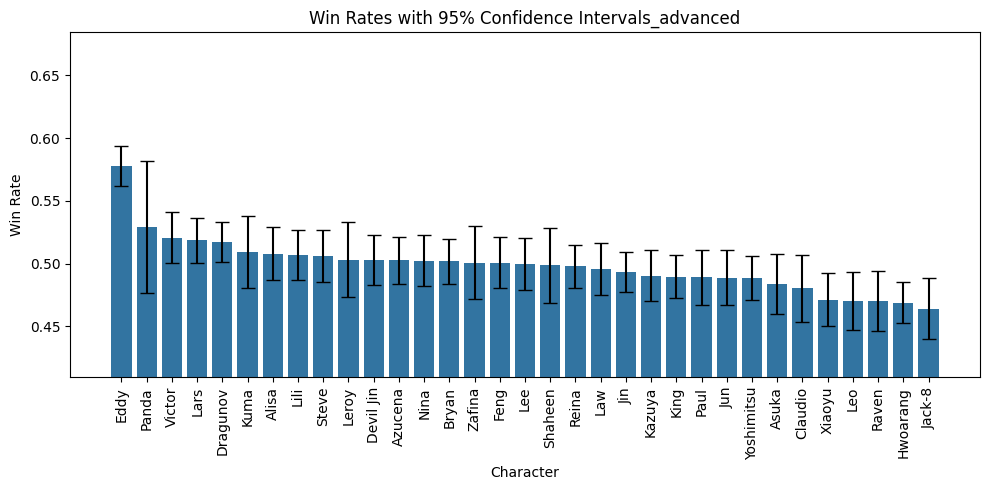

In [22]:
rank_counts = get_rank_distribution(unique_players)
plot_rank_distribution(rank_counts)
character_counts = get_most_popular_characters(unique_players)
plot_most_popular_characters(character_counts, 'all')
win_rates, intervals = calculate_win_rates_with_confidence_interval(master_df)
plot_win_rates(win_rates, 'all')


for bracket in brackets_dict:
    character_counts = get_most_popular_characters(brackets_dict[bracket]['players'])
    games = brackets_dict[bracket]['games']
    min_winrate = min(win_rates.values())
    max_winrate = max(win_rates.values())
    ylim = (min(min_winrate - 0.05, 0.45) , max(max_winrate + 0.05, 0.6))
    win_rates, intervals = calculate_win_rates_with_confidence_interval(games)
    plot_most_popular_characters(character_counts, bracket)
    plot_win_rates_with_confidence_intervals(win_rates, intervals, bracket_name=bracket, ylim=ylim)

In [ ]:
calculate_percentiles(rank_counts)

{'Beginner': 0.0,
 '1st Dan': 4.948214953158345,
 '2nd Dan': 6.557228806713368,
 'Fighter': 7.972726943898528,
 'Strategist': 9.921749719673494,
 'Combatant': 11.5904459904267,
 'Brawler': 13.336910259347231,
 'Ranger': 15.732646885060102,
 'Cavalry': 17.451379929827944,
 'Warrior': 19.844705144744935,
 'Assailant': 24.111696548065446,
 'Dominator': 27.649839038329375,
 'Vanquisher': 31.333871881744415,
 'Destroyer': 37.118243528376276,
 'Eliminator': 42.14543218509989,
 'Garyu': 47.56387224345603,
 'Shinryu': 59.10970713415884,
 'Tenryu': 65.94002821350631,
 'Mighty Ruler': 72.12167978876042,
 'Flame Ruler': 79.4240345314026,
 'Battle Ruler': 84.16004533452296,
 'Fujin': 88.04482812669552,
 'Raijin': 92.79711595268813,
 'Kishin': 95.20068966348762,
 'Bushin': 96.87963443012335,
 'Tekken King': 97.97260637335873,
 'Tekken Emperor': 98.91365943645329,
 'Tekken God': 99.39533874293154,
 'Tekken God Supreme': 99.69676509241732,
 'God of Destruction': 99.84808111985917}

In [11]:
# quick test to make sure the average win rate is close to 50%
# it should be exactly 50% since there is a win and a loss for each game
# but that is not the case since we are not considering the play rate of each character in this simple calculation

win_rates, _ = calculate_win_rates_with_confidence_interval(master_df)

average_win_rate = sum(win_rates.values()) / len(win_rates)
if abs(average_win_rate - 0.5) < 0.05:
    print(f"The average win rate ({average_win_rate}) is close to 50%.")
else:
    print(f"The average win rate ({average_win_rate})is not close to 50%.")


Number of mirror matches: 34920
Number of matches with draws: 0
The average win rate (0.49766602378538816) is close to 50%.


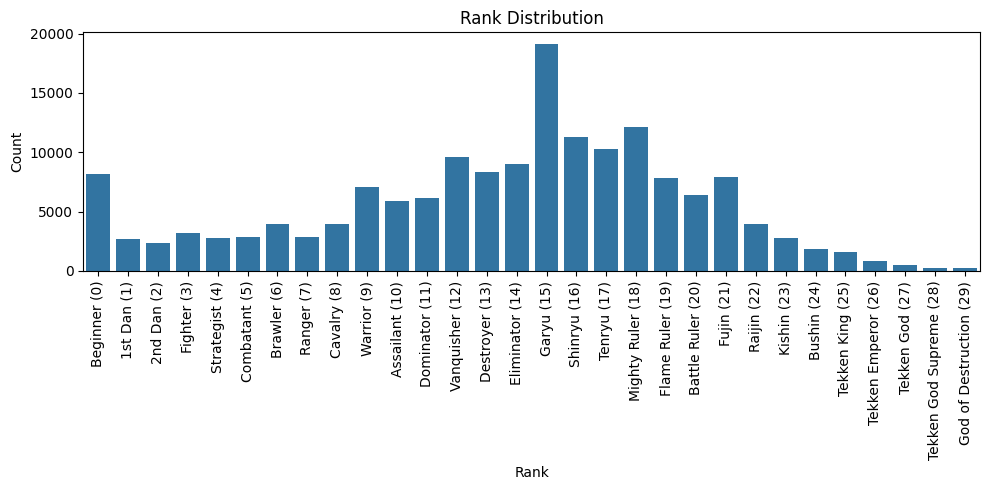

In [12]:
plot_rank_distribution(rank_counts)

In [13]:
# lets count how many players there are on each platform using unique_players
platform_counts = Counter([data['platform'] for user_id, data in unique_players.items()])
platform_counts = dict(platform_counts)
platform_counts = {k: v for k, v in sorted(platform_counts.items(), key=lambda item: item[1], reverse=True)}

# replace the platform names with the actual names from the platform dictionary
platform_counts = {platform_dict[k]: v for k, v in platform_counts.items()}

# lets normalize the counts
total = sum(platform_counts.values())
platform_counts = {k: v/total for k, v in platform_counts.items()}

# combine ps? and xbox? into a single category
platform_counts['console'] = platform_counts[platform_dict[8]] + platform_counts[platform_dict[9]]


platform_counts

{'pc': 0.515607856376373,
 'console/PS?': 0.404001736215773,
 'console/XBOX?': 0.08039040740785397,
 'console': 0.484392143623627}

In [14]:
# let's save the unique players dictionary to a csv file

with open('unique_players.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'rank', 'char', 'platform', 'tekken_power', 'characters'])
    for user_id, data in unique_players.items():
        writer.writerow([user_id, data['rank'], data['char'], platform_dict[data['platform']], data['tekken_power'], data['characters']])

# now let's do the same for the master dataframe
    
# let's first remove duplicate replays based on the battleId   

# let's save the master dataframe to a csv file
master_df.to_csv('replays.csv', index=False)

In [15]:
import yaml

win_rates, win_rates_intervals = calculate_win_rates_with_confidence_interval(master_df)
# Calculate win rates for each bracket
beginner_win_rates, beginner_win_rates_intervals = calculate_win_rates_with_confidence_interval(beginner_games)
intermediate_win_rates, intermediate_win_rates_intervals = calculate_win_rates_with_confidence_interval(intermediate_games)
advanced_win_rates, advanced_win_rates_intervals = calculate_win_rates_with_confidence_interval(advanced_games)

Number of mirror matches: 34920
Number of matches with draws: 0
Number of mirror matches: 10981
Number of matches with draws: 0
Number of mirror matches: 15947
Number of matches with draws: 0
Number of mirror matches: 1689
Number of matches with draws: 0


In [16]:
# Compile the visual data into a single YAML report
report_data = {
    'Number of unique players': len(unique_players),
    'Number of beginner players': len(beginner_players),
    'Number of intermediate players': len(intemediate_players),
    'Number of advanced players': len(advanced_players),
    'Number of unique games': len(master_df),
    'Number of beginner games': len(beginner_games),
    'Number of intermediate games': len(intermediate_games),
    'Number of advanced games': len(advanced_games),
    'Average win rate': average_win_rate,
    'Rank distribution': rank_counts,
    'Platform distribution': platform_counts,
    'Character counts': character_counts,
    'Beginner win rates': beginner_win_rates,
    'Intermediate win rates': intermediate_win_rates,
    'Advanced win rates': advanced_win_rates,
}

with open('report.yaml', 'w') as f:
    yaml.safe_dump(report_data, f, sort_keys=False)
